In [2]:
import pandas as pd
import numpy as np
import sqlite3
import os
import sys
import folium
import folium.plugins
import osmnx
import geopandas as gpd
import sklearn
import scipy
from matplotlib import pyplot as plt
import pickle
from shapely.geometry import Point, LineString, Polygon, MultiPoint, MultiPolygon
from shapely.ops import unary_union, nearest_points
import time

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import pairwise_distances

import itertools
! pip install anytree
import anytree
from anytree import Node, RenderTree

pd.options.display.max_rows = 4000
np.set_printoptions(threshold=sys.maxsize)

osmnx.config(use_cache=True, log_console=True)

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


# helpers

In [3]:
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

def haversine(x, y):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.

    """

    lon1, lat1, lon2, lat2 = map(np.radians, [x[0], x[1], y[0], y[1]])
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

def haversine_points(A, B):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.

    """

    lon1, lat1, lon2, lat2 = map(np.radians, [A.y, A.x, B.y, B.x])
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


# fetch data

In [ ]:
fn = 'points.sqlite'
points = pd.read_sql('select * from points where not banned', sqlite3.connect(fn))
print(len(points))

#region = osmnx.geocode_to_gdf({'city':'Freiberg'})
region = osmnx.geocode_to_gdf({'state':'Saxony'})
#region = osmnx.geocode_to_gdf({'state':'Brandenburg'})
#region = osmnx.geocode_to_gdf({'country':'Germany'})
poly = region.iloc[0].geometry
points = gpd.GeoDataFrame(points, geometry=gpd.points_from_xy(points.lon, points.lat))
points = points[points.geometry.within(poly)]

In [ ]:
points.to_csv('german_points.csv', index=True)

In [4]:
points = pd.read_csv('german_points.csv', index_col=0)

In [ ]:
print(len(points))
points.head(1)

In [63]:
points.loc[points.id.isin(range(1000000,1040000)), 'comment'] = points.loc[points.id.isin(range(1000000,1040000)), 'comment'].str.encode("cp1252",errors='ignore').str.decode('utf-8', errors='ignore')

points.datetime = pd.to_datetime(points.datetime)
points['text'] = points['comment'] + '\n\n―' + points['name'].fillna('Anonymous') + points.datetime.dt.strftime(', %B %Y').fillna('')

rads = points[['lon', 'lat', 'dest_lon', 'dest_lat']].values.T

points['distance_from_spot'] = haversine_np(*rads)

groups = points.groupby(['lat', 'lon'])

places = groups[['country']].first()
places['rating'] = groups.rating.mean().round()
places['wait'] = points[~points.wait.isnull()].groupby(['lat', 'lon']).wait.mean()
places['distance_from_spot'] = points[~points.distance_from_spot.isnull()].groupby(['lat', 'lon']).distance_from_spot.mean()
places['text'] = groups.text.apply(lambda t: '\n\n'.join(t.dropna()))


places['country_group'] = places.country.replace(['BE', 'NL', 'LU'], 'BNL')
places.country_group = places.country_group.replace(['CH', 'AT', 'LI'], 'ALP')
places.country_group = places.country_group.replace(['SI', 'HR', 'BA', 'ME', 'MK', 'AL', 'RS', 'TR'], 'BAL')
places.country_group = places.country_group.replace(['SK', 'HU'], 'SKHU')
places.country_group = places.country_group.replace('MC', 'FR')

places.reset_index(inplace=True)
# make sure high-rated are on top
places.sort_values('rating', inplace=True, ascending=False)

callback = """\
function (row) {
    var marker;
    var color = {1: 'red', 2: 'orange', 3: 'yellow', 4: 'lightgreen', 5: 'lightgreen'}[row[2]];
    var opacity = {1: 0.3, 2: 0.4, 3: 0.6, 4: 0.8, 5: 0.8}[row[2]];
    var point = new L.LatLng(row[0], row[1])
    marker = L.circleMarker(point, {radius: 5, weight: 1 + 1 * (row[2] == 5), fillOpacity: opacity, color: 'black', fillColor: color});

    marker.on('click', function(e) {
        if ($$('.topbar.visible')) return

        points = [point]

        setTimeout(() => {
            bar('.sidebar.show-spot')
            $$('#spot-header').innerText = `${row[0].toFixed(5)}, ${row[1].toFixed(5)}`
            $$('#spot-summary').innerText = `Rating: ${row[2].toFixed(0)}/5
Waiting time in minutes: ${Number.isNaN(row[4]) ? '-' : row[4].toFixed(0)}
Ride distance in km: ${Number.isNaN(row[5]) ? '-' : row[5].toFixed(0)}`

            $$('#spot-text').innerText = row[3];
            if (!row[3] && Number.isNaN(row[5])) $$('#extra-text').innerHTML = 'No comments/ride info. To hide points like this, check out the <a href=/light.html>lightweight map</a>.'
            else $$('#extra-text').innerHTML = ''
        },100)

        L.DomEvent.stopPropagation(e)
    })

    // if(row[2] >= 4) marker.bringToFront()

    return marker;
};
"""


In [ ]:
len(places)

In [ ]:
places.head()

# naive close points filtering

In [ ]:
places['keep'] = False

In [ ]:
counter = 0
i = 0
for l, place in places.iterrows():
    for k, other in places.iterrows():
        if haversine_np(place.lon,place.lat,other.lon,other.lat) < 0.017 and place.id != other.id:
            #print(l,k)
            places.loc[l, 'keep'] = True
            places.loc[k, 'keep'] = True
            counter += 1
    i += 1
    if i % 100 == 0:
        print(i, counter)

counter
close = places[places.keep]

# single (shortest) linkage agglomerative clustering

In [ ]:

# 50 meter distance


X = np.array(places[['lon','lat']])

M = pairwise_distances(X,X, metric=haversine, n_jobs=-1)

clustering = AgglomerativeClustering(n_clusters=None, linkage='single', compute_distances=True, affinity='precomputed', distance_threshold=0.05)
clustering.fit(M)


In [5]:
M = np.loadtxt('M.txt')
clustering = AgglomerativeClustering(n_clusters=100, linkage='average', compute_distances=True, affinity='precomputed')
clustering.fit(M)

AgglomerativeClustering(affinity='precomputed', compute_distances=True,
                        linkage='average', n_clusters=100)

In [ ]:
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(clustering, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [28]:
with open("germany_100cluster_average_from_german_points.pkl", "wb") as f:
    pickle.dump(clustering, f)

# select closest spots at threshold from clusters

In [ ]:
# all models are the same so far
with open("germany_50meter_single_from_german_points.pkl", "rb") as f:
    clustering = pickle.load(f)

In [ ]:
threshold = 0.05
close_links = clustering.children_[clustering.distances_ < threshold]

# establish tree of spots
# each subtree contains spots that are sufficiently close to each other
a = [0] * 2 * len(places)
root = Node('root')

ii = itertools.count(len(places))
for x in close_links:
    num = next(ii)
    a[num] = Node(num, parent=root)
    if x[0] < len(places):
        a[x[0]] = Node(x[0], parent=a[num])
    else:
        a[x[0]].parent = a[num]
    
    if x[1] < len(places):
        a[x[1]] = Node(x[1], parent=a[num])
    else:
        a[x[1]].parent = a[num]


In [ ]:
"""
for pre, fill, node in RenderTree(root):
    print("%s%s" % (pre, node.name))
"""

In [ ]:
# find the clusters
clusters = []
for subtree in root.children:
    cluster = []
    for leaf in subtree.leaves:
        cluster.append(leaf.name)
    clusters.append(cluster)

# merge points
for cluster in clusters:
    merged_spot = places.iloc[cluster[0]]
    lat = merged_spot.lat
    lon = merged_spot.lon
    for spot in cluster[1:]:
        spot = places.iloc[spot]
        points.loc[(points.lat == spot.lat) & (points.lon == spot.lon), ['lat','lon']] = [lat,lon]

# rerun fetching the places

# map

In [11]:
m = folium.Map(prefer_canvas=True, control_scale=True)

for country, group in places[places.cluster == 3].groupby('country_group'):
    cluster = folium.plugins.FastMarkerCluster(group[['lat', 'lon', 'rating', 'text', 'wait', 'distance_from_spot']].values, disableClusteringAtZoom=7, spiderfyOnMaxZoom=False, bubblingMouseEvents=False, callback=callback).add_to(m)
m

In [ ]:
close.to_csv('close_17meters_germany.csv', index=True)


# service station


## working with clusters

In [64]:
# TESTED FOR PARKING ... RUNS QUITE FAST IN COMPARISON TO OTHER APPROACHES

places = gpd.GeoDataFrame(places, geometry=gpd.points_from_xy(places.lon, places.lat), crs='EPSG:4326')

In [66]:
places['cluster'] = clustering.labels_
places['parking_id'] = None

In [68]:
# inspired by https://github.com/gboeing/osmnx/blob/3822ed659f1cc9f426a990c02dd8ca6b3f4d56d7/osmnx/utils_geo.py#L420
def circle(row):
    point = row.geometry
    earth_radius = 6_371_009  # meters
    dist = 30
    delta_lat = (dist / earth_radius) * (180 / np.pi)
    return point.buffer(delta_lat)

places.geometry = places.apply(circle, axis=1)

In [77]:
def get_parking(row, areas):
    this = areas[row.geometry.intersects(areas.geometry)]
    if not this.empty:
        return this.index[0]
    else:
        return None
    
    

for i in range(0,100):
    current_cluster = places.loc[places.cluster == i]
    polys = MultiPolygon(current_cluster.geometry.to_list())
    current_region = polys.convex_hull

    start = time.time()

    parking = osmnx.geometries.geometries_from_polygon(current_region, tags={'amenity': 'parking'})
    print(time.time()-start)
    start = time.time()

    parking = parking.loc['way']
    places.loc[places.cluster == i, 'parking_id'] = current_cluster.apply(lambda row: get_parking(row, parking), axis=1)
    """
    all_parking = parking.geometry.unary_union
    current_cluster['at_parking'] = current_cluster.geometry.apply(lambda x: x.intersects(all_parking) or (haversine_points(x, nearest_points(x, all_parking)[1]) < 30/1000))
    """
    print(time.time()-start)
    print(i)

0.32158994674682617
0.023329496383666992
0


## query for each spot

In [ ]:
places = gpd.GeoDataFrame(places, geometry=gpd.points_from_xy(places.lon, places.lat))

In [ ]:
global counter
counter = 0
def check_for_service_station(row):
    check_for_service_station.counter += 1
    print(check_for_service_station.counter)
    service = osmnx.geometries.geometries_from_point((row.lat, row.lon), tags={'amenity': 'parking'}, dist=100)
    return not service[service.geometry.contains(row.geometry)].empty

check_for_service_station.counter = 0

In [ ]:
# 5 min for saxony
places['service_station'] = places.apply(check_for_service_station, axis=1)

In [ ]:
osmnx.geometries.geometries_from_point((48.33628, 11.61126), tags={'highway': 'services'})

## query all service stations once then check

In [ ]:
places = gpd.GeoDataFrame(places, geometry=gpd.points_from_xy(places.lon, places.lat))
places['id'] = places.index
places['corrected_position_lat'] = None
places['corrected_position_lon'] = None
area = 'Germany'

In [ ]:
# USE THIS
# speedup
cf = '["amenity"~"fuel|parking"]'
G = osmnx.graph_from_place(area, custom_filter=cf)
cf = '["highway"~"services"]'
G = osmnx.graph_from_place(area, custom_filter=cf)
fig, ax = osmnx.plot_graph(G)
#"natural"~"water"

In [ ]:
start = time.time()

parking = osmnx.geometries.geometries_from_place('France', tags={'amenity': 'parking'})
print(time.time()-start)
start = time.time()

parking = parking.loc['way']
all_parking = parking.geometry.unary_union
places['at_parking'] = places.geometry.apply(lambda x: x.intersects(all_parking) or (haversine_points(x, nearest_points(x, all_parking)[1]) < 30/1000))
print(time.time()-start)

In [ ]:
len(parking)

In [ ]:
# 0.5 min for saxony, 7 min for germany, speedup after caching and querying before
# like 100 min for Germany without optimization

start = time.time()

# additional area around service station; tested for Brandenburg
services_threshold = 30 # meters
fuel_threshold = 30 # meters
parking_threshold = 30 # meters

service = osmnx.geometries.geometries_from_place(area, tags={'highway': 'services'})
print(time.time()-start)
start = time.time()

service = service.loc['way']
all_services = service.geometry.unary_union
# [0] would be the point itself
places['at_services'] = places.geometry.apply(lambda x: x.intersects(all_services) or (haversine_points(x, nearest_points(x, all_services)[1]) < services_threshold/1000))
print(time.time()-start)
start = time.time()

fuel = osmnx.geometries.geometries_from_place(area, tags={'amenity': 'fuel'})
print(time.time()-start)
start = time.time()

# can be nodes or ways
all_fuel = fuel.geometry.unary_union
places['at_fuel'] = places.geometry.apply(lambda x: x.intersects(all_fuel) or (haversine_points(x, nearest_points(x, all_fuel)[1]) < fuel_threshold/1000))
print(time.time()-start)
start = time.time()

parking = osmnx.geometries.geometries_from_place(area, tags={'amenity': 'parking'})
print(time.time()-start)
start = time.time()

parking = parking.loc['way']
all_parking = parking.geometry.unary_union
places['at_parking'] = places.geometry.apply(lambda x: x.intersects(all_parking) or (haversine_points(x, nearest_points(x, all_parking)[1]) < parking_threshold/1000))
print(time.time()-start)



In [ ]:
# speedup after caching and querying before
# correction: working :)

def get_services_id(row):
    if row.at_services:
        # first cover spots within service stations  
        services = osmnx.geometries.geometries_from_point((row.lat, row.lon), tags={'highway': 'services'})
        services = services.loc['way']     
        services = services[services.geometry.contains(row.geometry)]
        if not services.empty:
            return services.index[0]
        
        # cover spots slightly outside of service station
        else:
            services = osmnx.geometries.geometries_from_point((row.lat, row.lon), tags={'highway': 'services'}, dist=services_threshold)
            services = services.loc['way'] 
            if not services.empty:                
                # also correct the position -> moving the point into the service station
                # lon <-> lat switch here !!!
                places.loc[row.id, ['corrected_position_lat', 'corrected_position_lon']] = (services.iloc[0].geometry.centroid.y, services.iloc[0].geometry.centroid.x)
                return services.index[0]
            else:
                return None
    else:
        return None

places['services_id'] = places.apply(get_services_id, axis=1)

# correct the positions where possible
for _, place in places[places.corrected_position_lat.notnull()].iterrows():
    points.loc[(points.lat == place.lat) & (points.lon == place.lon), ['lat','lon']] = [place['corrected_position_lat'], place['corrected_position_lon']]

g= places.groupby('services_id')
clusters = list(filter(lambda x: len(x) > 1, g.id.apply(list).to_list()))

for cluster in clusters:
    merged_spot = places.loc[cluster[0]]
    lat = merged_spot.lat
    lon = merged_spot.lon
    for spot in cluster[1:]:
        spot = places.loc[spot]
        points.loc[(points.lat == spot.lat) & (points.lon == spot.lon), ['lat','lon']] = [lat,lon]



In [ ]:


# speedup after caching and querying before

def get_fuel_id(row):
    if row.at_fuel and row.services_id is None:
        # first cover spots within service stations  
        services = osmnx.geometries.geometries_from_point((row.lat, row.lon), tags={'amenity': 'fuel'})   
        services = services.loc['way']
        services = services[services.geometry.contains(row.geometry)]
        if not services.empty:
            return services.index[0]
        
        # cover spots slightly outside of fuel or if fuel is a node
        else:
            services = osmnx.geometries.geometries_from_point((row.lat, row.lon), tags={'amenity': 'fuel'}, dist=fuel_threshold) 
            if not services.empty:
                return services.index[0]
            else:
                return None
    else:
        return None

places['fuel_id'] = places.apply(get_fuel_id, axis=1)

g= places.groupby('fuel_id')
clusters = list(filter(lambda x: len(x) > 1, g.id.apply(list).to_list()))

for cluster in clusters:
    merged_spot = places.loc[cluster[0]]
    lat = merged_spot.lat
    lon = merged_spot.lon
    for spot in cluster[1:]:
        spot = places.loc[spot]
        points.loc[(points.lat == spot.lat) & (points.lon == spot.lon), ['lat','lon']] = [lat,lon]



In [ ]:
def get_parking_id(row):
    if row.at_parking and row.services_id is None and row.fuel_id is None:
        # first cover spots within service stations  
        services = osmnx.geometries.geometries_from_point((row.lat, row.lon), tags={'amenity': 'parking'})
        services = services.loc['way']     
        services = services[services.geometry.contains(row.geometry)]
        if not services.empty:
            return services.index[0]
        
        # cover spots slightly outside of service station
        else:
            services = osmnx.geometries.geometries_from_point((row.lat, row.lon), tags={'amenity': 'parking'}, dist=parking_threshold) 
            if not services.empty:
                services = services.loc['way']
                return services.index[0]
            else:
                return None
    else:
        return None

places['parking_id'] = places.apply(get_parking_id, axis=1)

g= places.groupby('parking_id')
clusters = list(filter(lambda x: len(x) > 1, g.id.apply(list).to_list()))

for cluster in clusters:
    merged_spot = places.loc[cluster[0]]
    lat = merged_spot.lat
    lon = merged_spot.lon
    for spot in cluster[1:]:
        spot = places.loc[spot]
        points.loc[(points.lat == spot.lat) & (points.lon == spot.lon), ['lat','lon']] = [lat,lon]



In [ ]:
places['id'] = places.index
g= places.groupby('services_id')
clusters = list(filter(lambda x: len(x) > 1, g.id.apply(list).to_list()))

for cluster in clusters:
    merged_spot = places.loc[cluster[0]]
    lat = merged_spot.lat
    lon = merged_spot.lon
    for spot in cluster[1:]:
        spot = places.loc[spot]
        points.loc[(points.lat == spot.lat) & (points.lon == spot.lon), ['lat','lon']] = [lat,lon]
# refetch places before checking on map

# close enough to street

In [ ]:
# check if spot is on road
threshold = 100 #meters
spot = (51.49219, 0.27456)
try:
    Network = osmnx.graph_from_point(spot, dist=threshold, network_type='drive')
except:
    print('no')


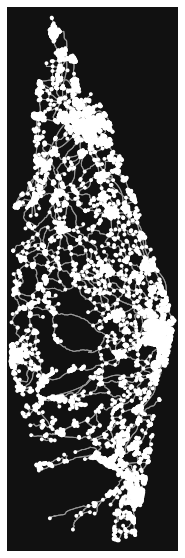

In [70]:
places.to_crs(epsg=4326, inplace=True)
current_cluster = places.loc[places.cluster == 0]
polys = MultiPolygon(current_cluster.geometry.to_list())
current_region = polys.convex_hull

Network = osmnx.graph_from_polygon(current_region, network_type='drive', retain_all=True, truncate_by_edge=True)
Network = osmnx.project_graph(Network, to_crs='epsg:3857')
fig, ax = osmnx.plot_graph(Network, figsize=(10,10))

In [97]:
# 3 s per spot
# distances result in meters if epsg is 3857 for Network and Spots -> but both have to be 4326 before !


a = places.loc[places.cluster == 0]
# switch back from circle to point
a['geometry'] = a.apply(lambda x: Point(x.lon, x.lat), axis=1)
a.to_crs(epsg=3857, inplace=True)
def get_nearest_road(row):    
    try:
        return osmnx.distance.nearest_edges(Network, row.geometry.x, row.geometry.y, return_dist=True)
    except:
        return None

a['nearest_road'] = a.apply(get_nearest_road, axis=1)

/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/till/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

In [ ]:
# takes more than 20 min for Saxony, about 0.5 min per spot (if network is whole Saxony)
# works well
# tested for Freiberg
# 10 min for Saxony

threshold = 0.05 # 100m

def get_nearest_road(row):    
    try:
        N = osmnx.graph_from_point((row.lat, row.lon), dist=threshold, network_type='drive')
        return osmnx.distance.nearest_edges(N, row.lon, row.lat, return_dist=True)
    except:
        return None

places['nearest_road'] = places.apply(get_nearest_road, axis=1)

In [ ]:
N = osmnx.graph_from_point((51.349009, 12.207173), dist=100, network_type='drive', retain_all=True)
fig, ax = osmnx.plot_graph(N, figsize=(100,100))